# In this notebook, we will use the KDE csv file for predicting tornado alley for the year 2030. We will also check the validity of our models by comparing the prediction with the testing set.

## First we are performing a prediction for the year 2030 using Gaussian white noise model and Linear Regression

/Users/pandey.176/mambaforge/envs/fermipy/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/pandey.176/mambaforge/envs/fermipy/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


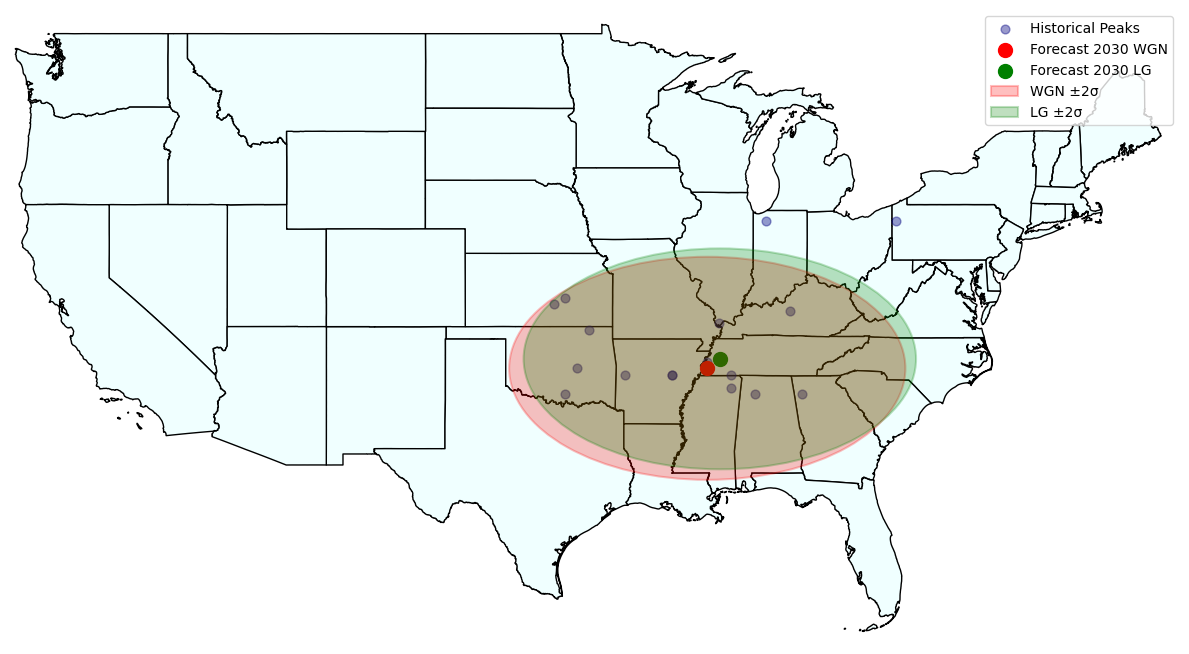

In [2]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from sklearn.linear_model import LinearRegression
from matplotlib.patches import Ellipse


df = pd.read_csv("data_tornado-density-peaks.csv")
df = df.dropna(subset=['peak_lat', 'peak_lon'])


df['mid_year'] = df['year_bin'].apply(lambda b: (int(b.split('-')[0]) + int(b.split('-')[1])) // 2)


X = df[['mid_year']]
y_lat = df['peak_lat']
y_lon = df['peak_lon']

lat_model = LinearRegression().fit(X, y_lat)
lon_model = LinearRegression().fit(X, y_lon)

forecast_year = 2030
lat_2030 = lat_model.predict([[forecast_year]])[0]
lon_2030 = lon_model.predict([[forecast_year]])[0]

# Residuals and standard deviations for LG model
lat_resid = y_lat - lat_model.predict(X)
lon_resid = y_lon - lon_model.predict(X)
lat_sigma_LG = lat_resid.std()
lon_sigma_LG = lon_resid.std()

# WGN model
lat_mu = df['peak_lat'].median()
lon_mu = df['peak_lon'].median()
lat_sigma_WGN = df['peak_lat'].std()
lon_sigma_WGN = df['peak_lon'].std()


us_states = gpd.read_file("https://www2.census.gov/geo/tiger/GENZ2022/shp/cb_2022_us_state_5m.zip")
excluded_states = ['ALASKA', 'HAWAII', 'PUERTO RICO', 'GUAM', 'AMERICAN SAMOA',
                   'COMMONWEALTH OF THE NORTHERN MARIANA ISLANDS', 'UNITED STATES MINOR OUTLYING ISLANDS']
us_states['NAME'] = us_states['NAME'].str.upper()
contiguous_states = us_states[~us_states['NAME'].isin(excluded_states)]

gdf_peaks = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['peak_lon'], df['peak_lat']), crs="EPSG:4326")

forecast_point_WGN = gpd.GeoDataFrame({'geometry': [Point(lon_mu, lat_mu)], 'label': ['2030 WGN']}, crs="EPSG:4326")
forecast_point_LG = gpd.GeoDataFrame({'geometry': [Point(lon_2030, lat_2030)], 'label': ['2030 LG']}, crs="EPSG:4326")

from matplotlib.patches import Ellipse

def draw_ellipse(ax, lon, lat, sigma_lon, sigma_lat, color, label, alpha=0.2, sigma_level=5):
    width = 2 * sigma_level * sigma_lon  # total width = 2 × σ × level
    height = 2 * sigma_level * sigma_lat
    ell = Ellipse(
        (lon, lat),
        width,
        height,
        edgecolor=color,
        facecolor=color,
        alpha=alpha,
        lw=1.5,
        label=label
    )
    ax.add_patch(ell)

fig, ax = plt.subplots(figsize=(12, 8))
contiguous_states.plot(ax=ax, color='azure', edgecolor='black')


gdf_peaks.plot(ax=ax, color='navy', markersize=40, alpha=0.4, label='Historical Peaks')


forecast_point_WGN.plot(ax=ax, color='red', markersize=100, label='Forecast 2030 WGN')
forecast_point_LG.plot(ax=ax, color='green', markersize=100, label='Forecast 2030 LG')

# Drawing 2σ ellipses
draw_ellipse(ax, lon_mu, lat_mu, lon_sigma_WGN, lat_sigma_WGN,
             color='red', label='WGN ±2σ', sigma_level=2, alpha=0.25)

draw_ellipse(ax, lon_2030, lat_2030, lon_sigma_LG, lat_sigma_LG,
             color='green', label='LG ±2σ', sigma_level=2, alpha=0.25)


ax.set_xlim(-125, -66)
ax.set_ylim(24, 50)

ax.set_axis_off()
ax.legend()
plt.tight_layout()
plt.show()


## Let's see how the testing data looks like and how it compares with our prediction

In [17]:
base_url = "https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/"


creation_date = "20250520"


all_years_data = []

for year in range(2021, 2025):
    print(f"\nProcessing year: {year}")

    details_file = f"StormEvents_details-ftp_v1.0_d{year}_c{creation_date}.csv.gz"


    def download_csv_gz(file_name):
        url = base_url + file_name
        try:
            r = requests.get(url)
            r.raise_for_status()
            return pd.read_csv(BytesIO(r.content), compression='gzip', low_memory=False)
        except Exception as e:
            print(f"Failed to load {file_name}: {e}")
            return None

    df_details = download_csv_gz(details_file)

    if df_details is None:
        continue

    df_details.columns = df_details.columns.str.lower()

    if 'event_id' not in df_details.columns:
        continue

    
    df_tornadoes = df_details[
    (df_details['event_type'] == 'Tornado') &
    (df_details['tor_f_scale'].isin(['EF0', 'EF1', 'EF2', 'EF3', 'EF4', 'EF5']))].copy()

    df_tornadoes['year'] = year  


    if df_tornadoes.empty:
        continue

    
    df_tornadoes['year'] = year
    all_years_data.append(df_tornadoes[['state', 'begin_lat', 'begin_lon', 'tor_f_scale', 'year']])


combined_df = pd.concat(all_years_data, ignore_index=True)


median_year = combined_df['year'].median()
combined_df['bin_median_year'] = median_year


combined_df['year_bin'] = f"{int(median_year)}"  # or something like "2021–2025"


binned_summary = combined_df.groupby( ['year_bin', 'state', 'begin_lat', 'begin_lon', 'tor_f_scale']).size().reset_index(name='count')


binned_summary.to_csv("try.csv", index=False)



Processing year: 2021

Processing year: 2022

Processing year: 2023

Processing year: 2024


In [19]:
print(binned_summary.head())

  year_bin    state  begin_lat  begin_lon tor_f_scale  count
0     2023  ALABAMA    30.2785   -87.7249         EF1      1
1     2023  ALABAMA    30.3103   -88.1384         EF0      1
2     2023  ALABAMA    30.3159   -87.7587         EF0      1
3     2023  ALABAMA    30.3410   -87.7910         EF1      1
4     2023  ALABAMA    30.3638   -87.7665         EF1      1


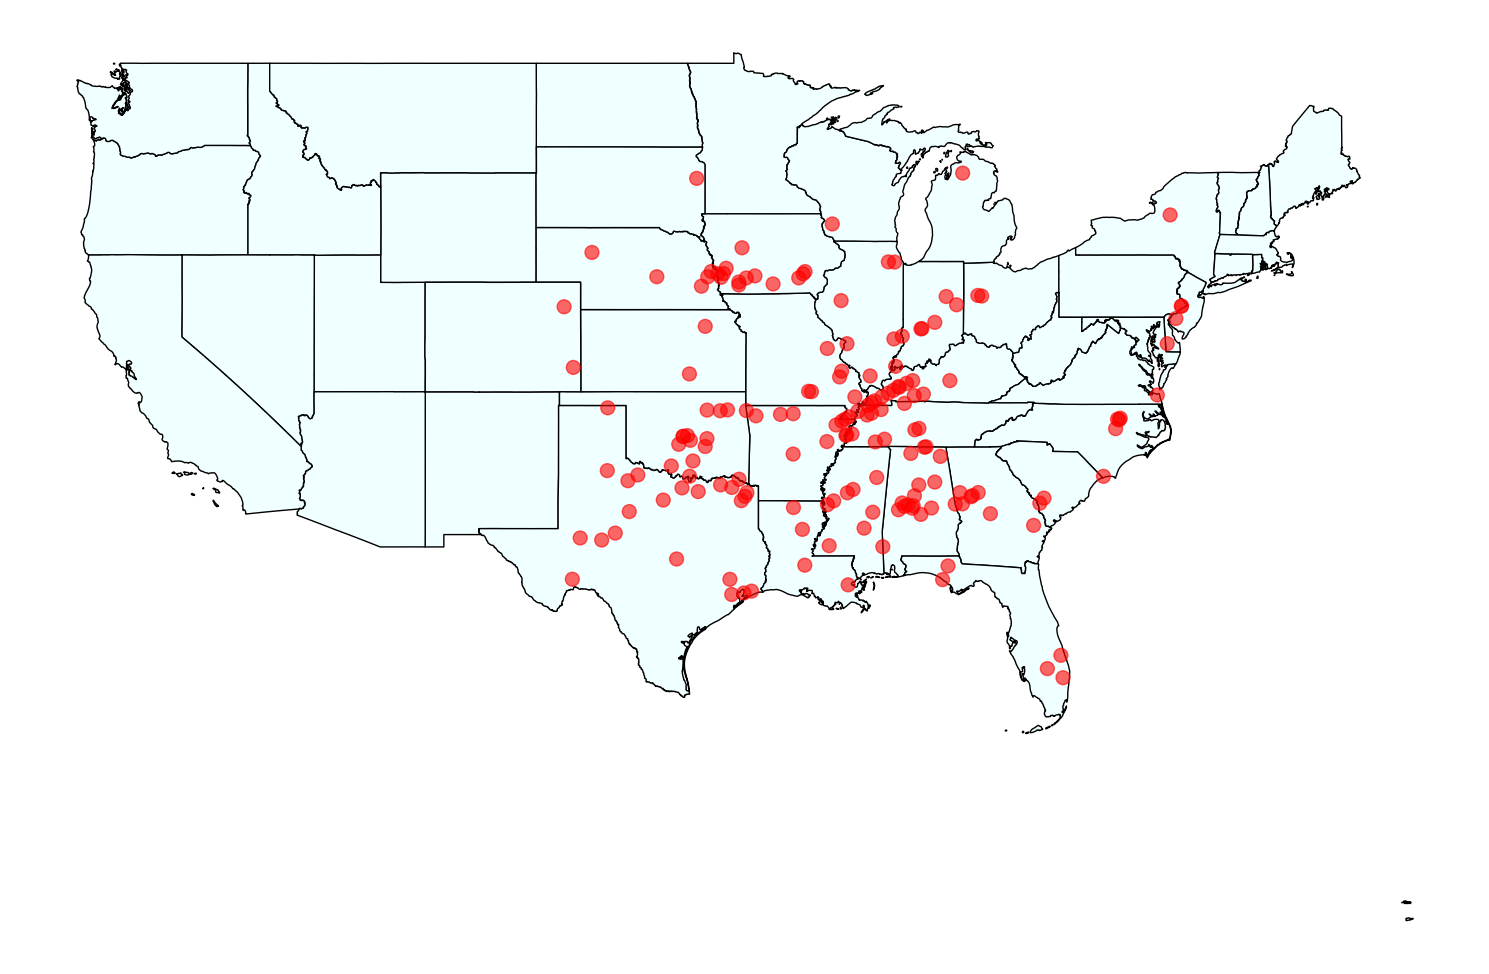

In [22]:
df = pd.read_csv("try.csv")
high_df = df[df['tor_f_scale'].isin(['EF3', 'EF4', 'EF5'])]


geometry = [Point(xy) for xy in zip(high_df['begin_lon'], high_df['begin_lat'])]
gdf = gpd.GeoDataFrame(high_df, geometry=geometry, crs="EPSG:4326")


us_states = gpd.read_file("https://www2.census.gov/geo/tiger/GENZ2022/shp/cb_2022_us_state_5m.zip")

excluded_states = [
    'ALASKA', 'HAWAII', 'PUERTO RICO', 'GUAM', 'AMERICAN SAMOA',
    'COMMONWEALTH OF THE NORTHERN MARIANA ISLANDS', 'UNITED STATES MINOR OUTLYING ISLANDS'
]

us_states['NAME'] = us_states['NAME'].str.upper()
contiguous_states = us_states[~us_states['NAME'].isin(excluded_states)]


fig, ax = plt.subplots(figsize=(15, 10))


contiguous_states.plot(ax=ax, color='azure', edgecolor='black')


gdf.plot(ax=ax, color='red', markersize=gdf['count'] * 100, alpha=0.6)



ax.set_axis_off()
plt.tight_layout()
plt.show()


## Performing a KDE analysis on testing data to find peak latitude and peak longitude values

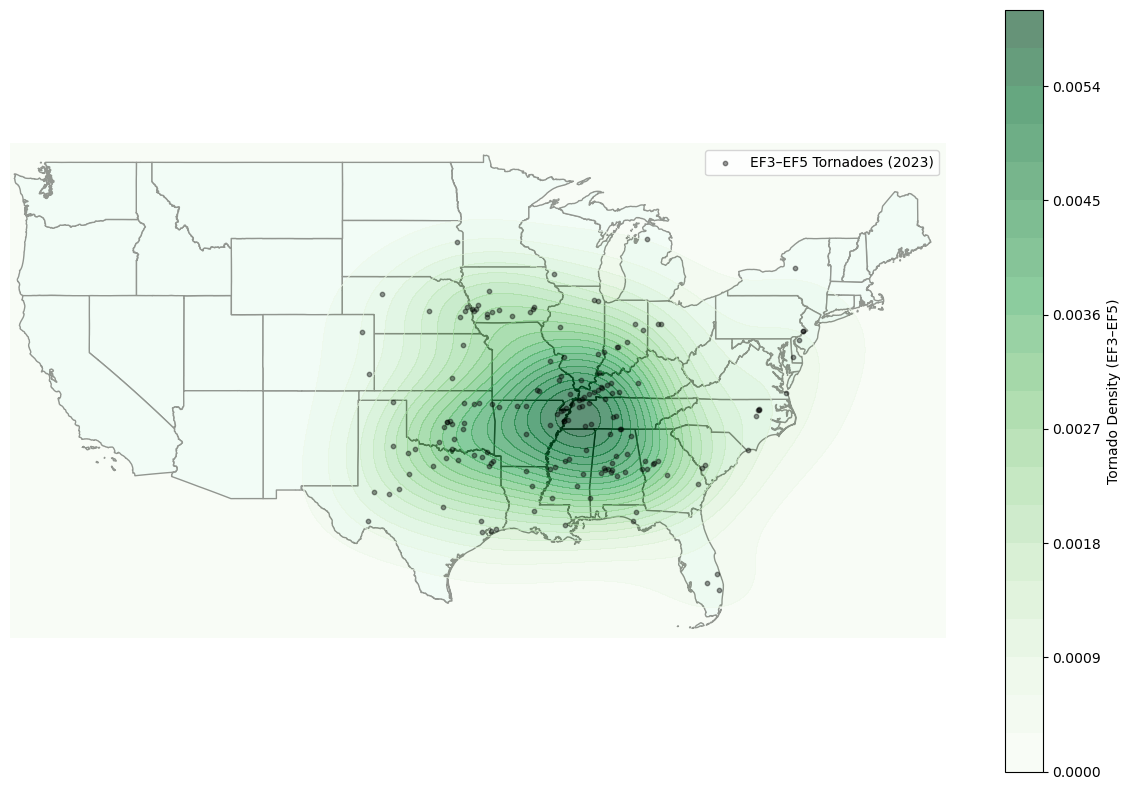

In [25]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import numpy as np
from scipy.stats import gaussian_kde


df = pd.read_csv("try.csv")
high_df = df[df['tor_f_scale'].isin(['EF3', 'EF4', 'EF5'])]


geometry = [Point(xy) for xy in zip(high_df['begin_lon'], high_df['begin_lat'])]
gdf = gpd.GeoDataFrame(high_df, geometry=geometry, crs="EPSG:4326")


us_states = gpd.read_file("https://www2.census.gov/geo/tiger/GENZ2022/shp/cb_2022_us_state_5m.zip")
excluded = ['ALASKA', 'HAWAII', 'PUERTO RICO', 'GUAM', 'AMERICAN SAMOA',
            'COMMONWEALTH OF THE NORTHERN MARIANA ISLANDS', 'UNITED STATES MINOR OUTLYING ISLANDS']
us_states['NAME'] = us_states['NAME'].str.upper()
contiguous_states = us_states[~us_states['NAME'].isin(excluded)]


x = gdf['begin_lon'].values
y = gdf['begin_lat'].values

if len(x) > 0:
    xy = np.vstack([x, y])
    kde = gaussian_kde(xy, bw_method=0.6)

    
    xmin, xmax = -125, -66
    ymin, ymax = 24, 50
    xx, yy = np.mgrid[xmin:xmax:200j, ymin:ymax:200j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    density = kde(positions).reshape(xx.shape)

    
    fig, ax = plt.subplots(figsize=(12, 8))
    contiguous_states.plot(ax=ax, color='azure', edgecolor='black')

    # Contour KDE
    contour = ax.contourf(xx, yy, density, levels=20, cmap='Greens', alpha=0.6)
    plt.colorbar(contour, ax=ax, label='Tornado Density (EF3–EF5)')

    
    ax.scatter(x, y, c='black', s=10, alpha=0.4, label='EF3–EF5 Tornadoes (2023)')

    
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_axis_off()
    ax.legend()
    plt.tight_layout()
    plt.show()
else:
    print("No EF3–EF5 tornado data found for 2024.")


## Linear Regression and Gaussian White Noise prediction for year 2023

/Users/pandey.176/mambaforge/envs/fermipy/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/pandey.176/mambaforge/envs/fermipy/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


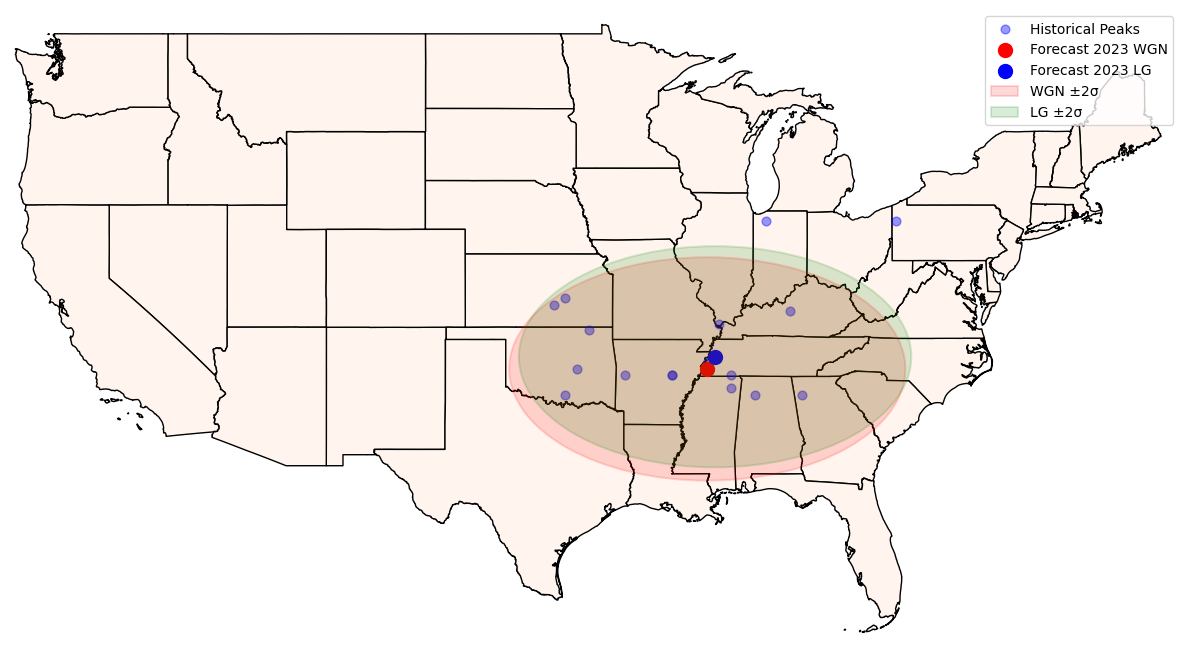

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from sklearn.linear_model import LinearRegression
from matplotlib.patches import Ellipse


df = pd.read_csv("data_tornado-density-peaks.csv")
df = df.dropna(subset=['peak_lat', 'peak_lon'])


df['mid_year'] = df['year_bin'].apply(lambda b: (int(b.split('-')[0]) + int(b.split('-')[1])) // 2)


X = df[['mid_year']]
y_lat = df['peak_lat']
y_lon = df['peak_lon']

lat_model = LinearRegression().fit(X, y_lat)
lon_model = LinearRegression().fit(X, y_lon)

forecast_year = 2023
lat_2030 = lat_model.predict([[forecast_year]])[0]
lon_2030 = lon_model.predict([[forecast_year]])[0]

# Residuals and standard deviations for LG model
lat_resid = y_lat - lat_model.predict(X)
lon_resid = y_lon - lon_model.predict(X)
lat_sigma_LG = lat_resid.std()
lon_sigma_LG = lon_resid.std()

# WGN model
lat_mu = df['peak_lat'].median()
lon_mu = df['peak_lon'].median()
lat_sigma_WGN = df['peak_lat'].std()
lon_sigma_WGN = df['peak_lon'].std()


us_states = gpd.read_file("https://www2.census.gov/geo/tiger/GENZ2022/shp/cb_2022_us_state_5m.zip")
excluded_states = ['ALASKA', 'HAWAII', 'PUERTO RICO', 'GUAM', 'AMERICAN SAMOA',
                   'COMMONWEALTH OF THE NORTHERN MARIANA ISLANDS', 'UNITED STATES MINOR OUTLYING ISLANDS']
us_states['NAME'] = us_states['NAME'].str.upper()
contiguous_states = us_states[~us_states['NAME'].isin(excluded_states)]

gdf_peaks = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['peak_lon'], df['peak_lat']), crs="EPSG:4326")

forecast_point_WGN = gpd.GeoDataFrame({'geometry': [Point(lon_mu, lat_mu)], 'label': ['2030 WGN']}, crs="EPSG:4326")
forecast_point_LG = gpd.GeoDataFrame({'geometry': [Point(lon_2030, lat_2030)], 'label': ['2030 LG']}, crs="EPSG:4326")

from matplotlib.patches import Ellipse

def draw_ellipse(ax, lon, lat, sigma_lon, sigma_lat, color, label, alpha=0.2, sigma_level=5):
    width = 2 * sigma_level * sigma_lon  # total width = 2 × σ × level
    height = 2 * sigma_level * sigma_lat
    ell = Ellipse(
        (lon, lat),
        width,
        height,
        edgecolor=color,
        facecolor=color,
        alpha=alpha,
        lw=1.5,
        label=label
    )
    ax.add_patch(ell)

fig, ax = plt.subplots(figsize=(12, 8))
contiguous_states.plot(ax=ax, color='seashell', edgecolor='black')


gdf_peaks.plot(ax=ax, color='blue', markersize=40, alpha=0.4, label='Historical Peaks')


forecast_point_WGN.plot(ax=ax, color='red', markersize=100, label='Forecast 2023 WGN')
forecast_point_LG.plot(ax=ax, color='blue', markersize=100, label='Forecast 2023 LG')

# Drawing 1σ ellipses
draw_ellipse(ax, lon_mu, lat_mu, lon_sigma_WGN, lat_sigma_WGN,
             color='red', label='WGN ±2σ', sigma_level=2, alpha=0.15)
draw_ellipse(ax, lon_2030, lat_2030, lon_sigma_LG, lat_sigma_LG,
             color='green', label='LG ±2σ', sigma_level=2, alpha=0.15)


ax.set_xlim(-125, -66)
ax.set_ylim(24, 50)

ax.set_axis_off()
ax.legend()
plt.tight_layout()
plt.show()


Our prediction values and observed data looks in good agreement